In [1]:
import numpy as np
import matplotlib.pyplot as plt
import compute_parameters
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import curve_fit
import pylab

from scipy.stats import shapiro

## Virtual machine trend

- pmd-small: predictability jikes > HotSpot > J9
- xalan-small: jikes > j9 > hotspot

In [2]:
trace_name = "pmd"
output_file_location = "/media/arjun/Shared/chaos/output_files"

In [34]:
def plot_actual_predicted(trace_name, jvm, history_size=40, 
                          model_type="fcn", output_file_location="/media/arjun/Shared/chaos/output_files"):
    start_point = 10000
    n_points = 5000
    
    if jvm == "jikes":
        jvm_name = "JikesRVM"
    elif jvm == "j9":
        jvm_name = "J9"
    else:
        jvm_name = "HotSpot"
    
    
    trace = pd.read_pickle(
                '../data/{}-small-{}-d-l64-p4096-w100000i.analyzed-1.pkl'.format(trace_name, jvm_name)
            ).to_numpy()[start_point:start_point+n_points]
    
    for hidden_size in hidden_sizes:
        predictions = np.load(
                    '{}/{}/{}/predictions_{}_{}_{}_{}.npy'.format(output_file_location, 
                                                                  trace_name, jvm, history_size, 1, hidden_size, 1))
        predictions = np.argsort(predictions)
        actual = []
        predicted = []

        for idx, point in enumerate(trace):
            actual.append(float(np.argmax(point)))
            predicted.append(predictions[history_size-1+idx, -1])
            
        n_points = 5000
        start_point = 0

        n_points = min(trace.shape[0]-start_point, n_points)

        plt.plot(range(start_point, start_point+n_points), actual, label='actual')
        plt.plot(range(start_point, start_point+n_points), predicted, label='predicted', alpha=0.7)
        plt.title("hidden size: {}".format(hidden_size))
        plt.legend()
        plt.show()
    
    return trace


def get_actual_predicted(trace_name, jvm, hidden_size, history_size=40,
                          model_type="fcn", output_file_location="/media/arjun/Shared/chaos/output_files"):
    start_point = 10000
    n_points = 5000
    
    if jvm == "jikes":
        jvm_name = "JikesRVM"
    elif jvm == "j9":
        jvm_name = "J9"
    else:
        jvm_name = "HotSpot"
    
    trace = pd.read_pickle(
                '../data/{}-small-{}-d-l64-p4096-w100000i.analyzed-1.pkl'.format(trace_name, jvm_name)
            ).to_numpy()[start_point:start_point+n_points]
    
    data = []
    
    predictions = np.load(
                    '{}/{}/{}/predictions_{}_{}_{}_{}.npy'.format(output_file_location, 
                                                                  trace_name, jvm, 
                                                                  history_size, 1, hidden_size, 1))
    predictions = np.argsort(predictions)
    for idx, point in enumerate(trace):
#         print("{}: {}".format(np.argmax(point), predictions[history_size-1+idx, -1]))
        actual = bin_to_val(int(np.argmax(point)))
        predicted = bin_to_val(predictions[history_size-1+idx, -1])
    
        data.append((actual, predicted))
    
    return data

In [19]:
def get_heatmaps(trace_name, trace, predictions, jvm="jikes"):
    prediction_map = {}
    
    hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
    
    for hidden_size in hidden_sizes:
    #     hidden_size = 8000
        heatmap = np.zeros((predictions.shape[1], predictions.shape[1]))
        predictions = np.load(
                    '{}/{}/{}/predictions_{}_{}_{}_{}.npy'.format(output_file_location, trace_name, 
                                                                            jvm, 40, 1, 
                                                                            hidden_size, 1))
        # predictions = np.argsort(predictions)

        heatmap[predictions.shape[1]-1, 0] = 0
        heatmap[0, 0] = 0

        for idx, point in enumerate(trace):
        #     print(predictions[history_size-1+idx, -1])
        #     print("{}, {}: {}".format(history_size, np.argmax(point), int(predictions[history_size-1+idx, -1])))
            heatmap[np.argmax(point), int(np.argsort(predictions[history_size-1+idx].flatten())[-1])] += 1

        prediction_map[hidden_size] = heatmap.copy()

        heatmap += 1e-50
        # print(np.sum(heatmap>1))
        # print(np.sum(heatmap, axis=0))
        heatmap = heatmap/np.sum(heatmap, axis=0)
        heatmap = heatmap*1000

        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.title("hidden layer size = {}".format(hidden_size))
        plt.imshow(heatmap, cmap='seismic', interpolation='nearest')
        plt.tight_layout()
    #     plt.savefig("output_files/plots/heatmap_{}.jpg".format(hidden_size), dpi=500)
        plt.show()
    
    return prediction_map

In [35]:
def mse_function(y, y1):
    return np.mean((y-y1)**2)

## precision and recall
def relevance_function(x, sigma=1.0, mu=0):
    return np.exp(-((x-mu)**2)/(2*(sigma**2)))/(sigma*np.sqrt(2*np.pi))


def alpha(y, y_pred, loss_function=mse_function, threshold=0.01):
    return loss_function(y, y_pred) < threshold


def recall(data, y_ref, loss_function=mse_function, relevance_threshold=0.3):
    num = 0
    din = 0
    for y_actual, y_pred in data:
        phi_y = relevance_function(y_actual, mu=y_ref)
        if phi_y > relevance_threshold:
            num += alpha(y_actual, y_pred, loss_function) * phi_y
            din += phi_y
    
    if din > 0:
        return num/din
    else:
        return 0

    

def existance_check(data, y_ref, loss_function=mse_function, relevance_threshold=0.3):
    num = 0
    din = 0
    exists = False
    for y_actual, y_pred in data:
        phi_y = relevance_function(y_actual, mu=y_ref)
        if phi_y > relevance_threshold:
            return True
    
    return False


def precision(data, y_ref, loss_function=mse_function, relevance_threshold=0.3):
    num = 0
    din = 0
    exists = False
    for y_actual, y_pred in data:
        phi_y1 = relevance_function(y_pred, mu=y_ref)
        if phi_y1 > relevance_threshold:
            exists = True
            num += alpha(y_actual, y_pred, loss_function) * phi_y1
            din += phi_y1
    
    if din > 0:
        return num/din
    elif exists:
        return 0
    else:
        return False

def f1_score(precision, recall, beta=1):
    if precision+recall > 0:
        return ((1+beta**2)*precision*recall)/(precision+recall)
    else:
        return 0
    

def bin_to_val(bin_idx):
    g_max = 1
    g_min = 3 * np.exp(-8)
    feature_dimension = 100
    multiplier = (np.log(g_max) - np.log(g_min))/feature_dimension # values from preprocess cache file
    
    return np.exp(bin_idx*multiplier + np.log(g_min))


def sup(arr, mode="max"):
    if mode == "max":
        return (np.mean(arr))
    elif mode == "999percentile":
        return np.mean(arr) + 5 * np.std(arr)


def get_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([1, 1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f))
    
    return np.mean(rademacher)

In [7]:
def get_distribution(loss_array):
#     print(loss_array)
#     print(loss_array.shape)
#     f = loss_array.flatten()
    f=np.sum(loss_array, axis=1)/loss_array.shape[1]
    f = f.flatten()
    print(f)
    plt.hist(f, bins='auto')
    plt.xlim(0, 0.12)
    plt.show()
    
    return f

In [8]:
def sup(arr, mode="max"):
    if mode == "max":
        return (max(arr))
    elif mode == "999percentile":
        return np.mean(arr) + 5 * np.std(arr)
    

def get_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([-1, 1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f))
    
    return np.mean(rademacher)


def get_mod_rademacher(loss_array):
    rademacher = []
    
    n_sigma = 2000
    
    for i in range(n_sigma):
        sigma_arr = np.random.choice([-1, 1], size=loss_array.shape)

        f = sigma_arr*loss_array
        f = np.sum(f, axis=1)/loss_array.shape[1]
        # print(f)
        rademacher.append(sup(f, mode="999percentile"))
    
    return np.mean(rademacher)

In [9]:
def get_average(loss_array):
    rademacher = []
    
    f = np.sum(loss_array, axis=1)/loss_array.shape[1]

    return np.mean(f)

In [ ]:
# loss = np.load("output_files/jikes/loss_40_1_1.npy")
# dist = get_distribution(loss)

# print(shapiro(dist))
# print("mean: {}, std: {}".format(np.mean(dist), np.std(dist)))
# print("Rademacher: {}".format(get_rademacher(loss)))
# print("Modified Rademacher: {}".format(get_mod_rademacher(loss)))

In [22]:
hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

history_sizes = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]

In [21]:
rademacher_jikes = []

for h_idx, history in enumerate(history_sizes):
    rademacher_history = []
    for hidden_size in hidden_sizes:
        print("history: {}, hidden_size: {}".format(history, hidden_size))
        loss_array = np.load("{}/{}/jikes/loss_{}_{}_1.npy".format(output_file_location, 
                                                                       trace_name, history, hidden_size))
        rademacher_history.append(get_mod_rademacher(loss_array))
    
    rademacher_jikes.append(rademacher_history)

history: 5, hidden_size: 1
history: 5, hidden_size: 2
history: 5, hidden_size: 3


KeyboardInterrupt: 

In [ ]:
for idx, history in enumerate(history_sizes):
    rademacher_history = rademacher_jikes[idx]
    plt.plot(hidden_sizes, rademacher_history, label="history: {}".format(history))

plt.legend()
plt.ylabel("Empirical Rademacher Complexity")
plt.xlabel("Hidden Layer Size")
plt.ylim((0.00025, 0.0006))
plt.tight_layout()
plt.show()

In [ ]:
hidden_size_idxs = [ 32, 37, 42, 46 ]

for hidden_size_idx in hidden_size_idxs:
    r_list = [ a[hidden_size_idx] for a in rademacher_jikes ]
    plt.plot(history_sizes, r_list, label="hidden_layer: {}".format(hidden_sizes[hidden_size_idx]))

plt.legend()
plt.ylabel("Empirical Rademacher Complexity")
plt.xlabel("history size")
plt.tight_layout()
plt.show()

In [ ]:
trace = plot_actual_predicted(trace_name, "jikes", history_size=50)

In [19]:
hidden_sizes = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                200, 300, 400, 500, 600, 700, 800, 900,
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000
            ]

In [21]:
history=40

jvm_list = [ 'jikes' ]
rademacher_list1 = []
average_list1 = []
fcn_param_list = []

for jvm_idx, jvm in enumerate(jvm_list):
    rademacher_history = []
    average_history = []
    for hidden_size in hidden_sizes:
        if jvm_idx == 0:
            fcn_param_list.append(compute_parameters.get_count(100, 100, [ hidden_size ], [ 'fcn' ]))
        print("history: {}, jvm:{}, hidden_size: {}, params: {}".format(history, jvm, hidden_size, fcn_param_list[-1]))
        loss_array = np.load("{}/{}/{}/loss_{}_{}_1.npy".format(output_file_location, 
                                                                       trace_name, jvm, history, hidden_size))
        rademacher_history.append(get_mod_rademacher(loss_array))
        average_history.append(get_average(loss_array))
    
    rademacher_list1.append(rademacher_history)
    average_list1.append(average_history)

history: 40, jvm:jikes, hidden_size: 1, params: 301
history: 40, jvm:jikes, hidden_size: 2, params: 502
history: 40, jvm:jikes, hidden_size: 3, params: 703
history: 40, jvm:jikes, hidden_size: 4, params: 904
history: 40, jvm:jikes, hidden_size: 5, params: 1105
history: 40, jvm:jikes, hidden_size: 6, params: 1306
history: 40, jvm:jikes, hidden_size: 7, params: 1507
history: 40, jvm:jikes, hidden_size: 8, params: 1708
history: 40, jvm:jikes, hidden_size: 9, params: 1909
history: 40, jvm:jikes, hidden_size: 10, params: 2110
history: 40, jvm:jikes, hidden_size: 20, params: 4120
history: 40, jvm:jikes, hidden_size: 30, params: 6130
history: 40, jvm:jikes, hidden_size: 40, params: 8140
history: 40, jvm:jikes, hidden_size: 50, params: 10150
history: 40, jvm:jikes, hidden_size: 60, params: 12160
history: 40, jvm:jikes, hidden_size: 70, params: 14170
history: 40, jvm:jikes, hidden_size: 80, params: 16180
history: 40, jvm:jikes, hidden_size: 90, params: 18190
history: 40, jvm:jikes, hidden_size:

In [22]:
jvm_list = [ 'jikes' ]
output_file_location_lstm = "/media/arjun/Shared/chaos/output_files/lstm"
rademacher_list2 = []
average_list2 = []
lstm_param_list = []

for jvm in jvm_list:
    rademacher_history = []
    average_history = []
    for hidden_size in hidden_sizes:
        lstm_param_list.append(compute_parameters.get_count(100, 100, [1000, hidden_size], ["lstm", "fcn"]))
        print("history: {}, jvm:{}, hidden_size: {}, params: {}".format(history, jvm, 
                                                                        hidden_size, lstm_param_list[-1]))
        loss_array = np.load("{}/{}/{}/loss_{}_{}_1.npy".format(output_file_location_lstm, 
                                                                       trace_name, jvm, 40, hidden_size))
        rademacher_history.append(get_mod_rademacher(loss_array))
        average_history.append(get_average(loss_array))
    
    rademacher_list2.append(rademacher_history)
    average_list2.append(average_history)

history: 40, jvm:jikes, hidden_size: 1, params: 1202201
history: 40, jvm:jikes, hidden_size: 2, params: 1203302
history: 40, jvm:jikes, hidden_size: 3, params: 1204403
history: 40, jvm:jikes, hidden_size: 4, params: 1205504
history: 40, jvm:jikes, hidden_size: 5, params: 1206605
history: 40, jvm:jikes, hidden_size: 6, params: 1207706
history: 40, jvm:jikes, hidden_size: 7, params: 1208807
history: 40, jvm:jikes, hidden_size: 8, params: 1209908
history: 40, jvm:jikes, hidden_size: 9, params: 1211009
history: 40, jvm:jikes, hidden_size: 10, params: 1212110
history: 40, jvm:jikes, hidden_size: 20, params: 1223120
history: 40, jvm:jikes, hidden_size: 30, params: 1234130
history: 40, jvm:jikes, hidden_size: 40, params: 1245140
history: 40, jvm:jikes, hidden_size: 50, params: 1256150
history: 40, jvm:jikes, hidden_size: 60, params: 1267160
history: 40, jvm:jikes, hidden_size: 70, params: 1278170
history: 40, jvm:jikes, hidden_size: 80, params: 1289180
history: 40, jvm:jikes, hidden_size: 90,

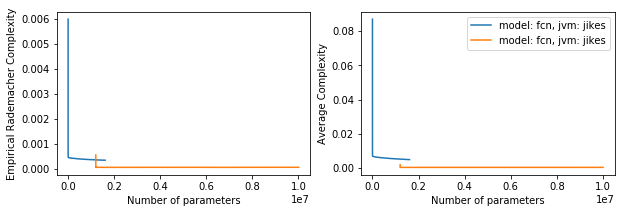

In [35]:
ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list1[idx]
    average_history = average_list1[idx]
    ax1.plot(fcn_param_list, rademacher_history, label="model: {}, jvm: {}".format("fcn", jvm))
    ax2.plot(fcn_param_list, average_history, label="model: {}, jvm: {}".format("fcn", jvm))

for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list2[idx]
    average_history = average_list2[idx]
    ax1.plot(lstm_param_list, rademacher_history, label="model: {}, jvm: {}".format("lstm", jvm))
    ax2.plot(lstm_param_list, average_history, label="model: {}, jvm: {}".format("fcn", jvm))

plt.legend()

ax1.figure.set_size_inches(10, 3)
ax2.figure.set_size_inches(10, 3)

ax1.set_ylabel("Empirical Rademacher Complexity")
ax1.set_xlabel("Number of parameters")
ax2.set_ylabel("Average Complexity")
ax2.set_xlabel("Number of parameters")
# plt.ylim((0.00006, 0.00008))
# plt.xlim((0, 0.2e7))
# plt.tight_layout()
plt.show()

In [91]:
data = get_actual_predicted(trace_name, "jikes", hidden_size=1000, history_size=40, 
                      model_type="lstm", output_file_location="/media/arjun/Shared/chaos/output_files/lstm")

55: 99
54: 99
52: 99
58: 55
68: 48
58: 50
58: 57
60: 65
60: 56
67: 56
62: 57
61: 57
61: 63
63: 58
68: 58
66: 58
69: 63
66: 63
69: 62
63: 65
66: 67
71: 69
65: 63
58: 62
68: 69
55: 61
54: 56
50: 65
53: 55
58: 48
67: 46
66: 46
58: 56
58: 63
63: 62
71: 56
61: 56
63: 63
68: 69
62: 57
67: 63
59: 65
62: 58
69: 63
64: 57
57: 58
62: 65
63: 62
68: 55
58: 63
65: 63
70: 65
54: 56
54: 62
54: 69
52: 48
66: 48
59: 48
65: 50
62: 67
69: 57
69: 61
57: 63
59: 69
60: 69
61: 55
67: 57
66: 57
68: 57
58: 63
58: 67
66: 65
68: 56
61: 56
69: 67
68: 63
67: 57
68: 69
63: 63
65: 63
70: 63
67: 62
63: 62
50: 69
56: 67
53: 62
52: 46
75: 55
75: 46
75: 50
72: 72
58: 72
60: 71
64: 69
66: 56
65: 57
68: 61
61: 67
65: 62
70: 65
67: 58
64: 62
66: 69
58: 67
68: 62
68: 62
60: 57
68: 65
67: 63
66: 57
68: 65
64: 67
68: 67
58: 65
59: 62
66: 65
54: 56
52: 57
54: 67
60: 48
67: 50
60: 48
62: 57
62: 63
70: 57
67: 63
68: 58
68: 69
55: 63
65: 65
65: 65
69: 55
68: 61
58: 62
57: 69
60: 63
68: 56
61: 56
66: 57
60: 63
66: 57
72: 67
54: 57

67: 67
66: 67
71: 69
66: 63
69: 67
69: 69
66: 67
71: 69
66: 69
66: 67
71: 69
66: 67
66: 67
71: 69
66: 67
67: 67
71: 69
66: 67
71: 63
66: 69
67: 67
71: 69
66: 67
66: 63
71: 69
66: 67
67: 67
71: 69
66: 67
69: 63
69: 69
67: 67
71: 65
66: 69
66: 63
71: 69
67: 67
66: 67
71: 69
66: 63
66: 67
71: 69
66: 67
70: 67
68: 69
66: 67
71: 69
67: 63
66: 67
71: 69
69: 67
72: 67
70: 69
72: 69
69: 69
71: 69
71: 69
72: 69
71: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
69: 69
72: 69
70: 69
69: 69
72: 69
69: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
69: 69
72: 69
70: 69
72: 69
70: 69
72: 69
70: 69
72: 69
69: 69
69: 69
73: 69
75: 69
75: 65
72: 70
69: 72
72: 72
73: 69
67: 65
69: 69
70: 70
72: 63
69: 69
69: 69
66: 69
66: 65
70: 65
66: 67
66: 67
65: 69
66: 62
66: 62
67: 62
65: 67
65: 67
70: 67
71: 62
72: 62
71: 69
69: 69
72: 69
70: 69
70: 69
71: 69
72: 69
70: 69
70: 69
72: 69
71: 69
70: 69
70: 69
72: 69
71: 69
71: 69
72: 69

70: 69
75: 69
75: 69
71: 69
70: 72
77: 72
74: 69
72: 69
73: 71
73: 71
73: 69
58: 69
67: 70
55: 70
58: 56
60: 67
61: 55
67: 56
60: 57
61: 57
60: 63
66: 57
69: 58
66: 57
57: 67
58: 69
60: 67
65: 55
69: 56
56: 57
66: 61
66: 69
69: 55
65: 67
64: 62
70: 65
67: 61
72: 61
73: 69
74: 63
74: 69
73: 70
72: 71
72: 71
73: 69
74: 69
73: 69
71: 69
72: 71
73: 70
73: 69
73: 69
74: 70
70: 70
70: 70
73: 71
69: 69
73: 69
73: 70
73: 69
72: 70
71: 70
71: 70
76: 69
76: 69
75: 69
72: 69
71: 69
70: 72
71: 69
72: 69
72: 69
72: 69
73: 69
75: 69
69: 69
68: 70
73: 72
78: 69
72: 65
70: 69
71: 75
73: 69
60: 69
64: 69
72: 70
72: 57
73: 61
72: 69
72: 69
58: 70
56: 69
58: 69
62: 56
69: 55
63: 56
72: 58
74: 69
72: 62
57: 69
54: 71
56: 69
58: 55
60: 48
67: 55
61: 56
59: 57
60: 63
66: 58
71: 57
62: 57
62: 67
61: 69
55: 58
58: 63
60: 58
59: 55
60: 56
60: 57
67: 57
67: 57
60: 57
61: 63
69: 67
59: 57
65: 58
68: 69
64: 57
67: 62
63: 65
64: 62
66: 63
66: 63
66: 61
68: 67
73: 67
73: 67
71: 65
74: 69
75: 70
73: 69
72: 71
72: 72

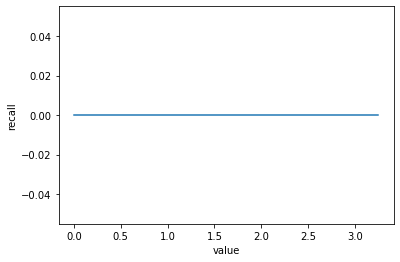

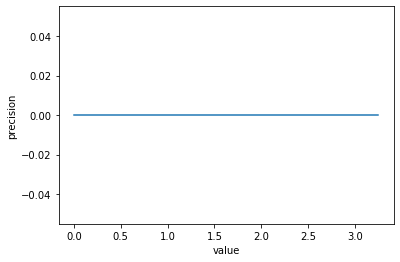

In [105]:
recall_vals = []
precision_vals = []
vals = []

for val in np.linspace(0, max_val, 50):
    vals.append(val)
    recall_vals.append(recall(data, val))
    precision_vals.append(precision(data, val))
#     print("{:.2f}: {}".format(val, recall(data, val)))

plt.plot(vals, recall_vals)
plt.xlabel("value")
plt.ylabel("recall")
# plt.xlim()
plt.show()

plt.plot(vals, precision_vals)
plt.xlabel("value")
plt.ylabel("precision")
plt.show()

In [12]:
data = get_actual_predicted(trace_name, "jikes", hidden_size=1000, history_size=40, 
                      model_type="lstm", output_file_location="/media/arjun/Shared/chaos/output_files/lstm")

max_val = np.max([ point[0] for point in data ])
max_val = max(max_val, np.max([ point[0] for point in data ]))

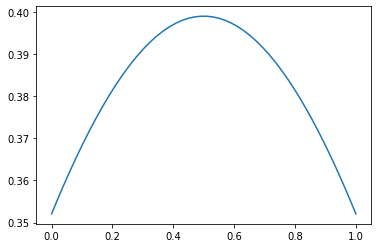

0.3989422784067213


In [38]:
rel_vals = []

for val in np.linspace(0, 1, 50):
    rel_vals.append(relevance_function(val, mu=0.5))

plt.plot(np.linspace(0, 1, 50), rel_vals)
plt.show()

print(relevance_function(1e-4))

max val in trace: 0.3093642446824047
min val in trace: 0.022465752482887427
Averages precision: 0.0, recall:0.0, f1_score: 0.0


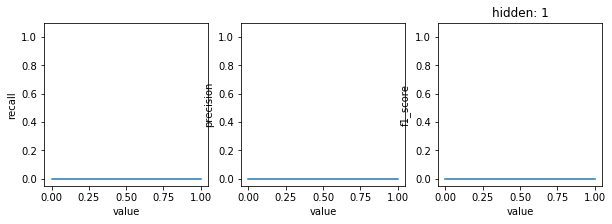

Averages precision: 0.0536588619838566, recall:0.4659498117733606, f1_score: 0.05945965923790493


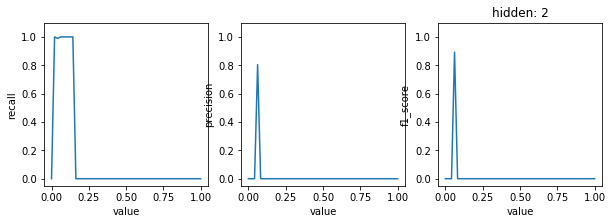

Averages precision: 0.06618637849376292, recall:0.6659498117733605, f1_score: 0.06642565441521056


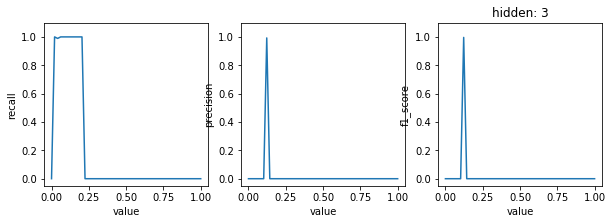

Averages precision: 0.065692748982723, recall:0.5862624185664771, f1_score: 0.06617612471861038


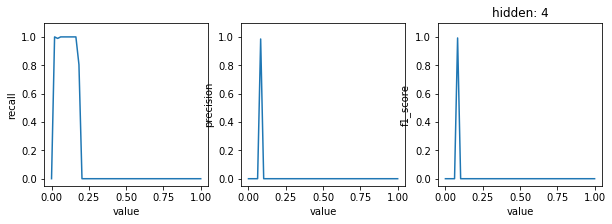

Averages precision: 0.13283613010151232, recall:0.6659498117733605, f1_score: 0.13308380120607194


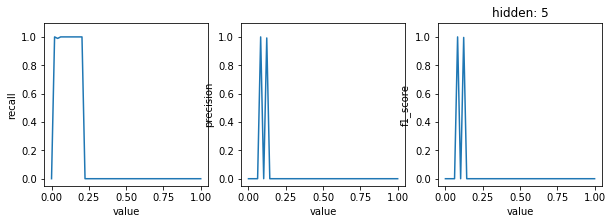

Averages precision: 0.06618637849434839, recall:0.6659498117733605, f1_score: 0.0664256544155054


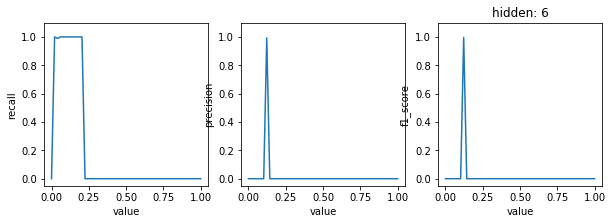

Averages precision: 0.12972458303103893, recall:0.6659498117733605, f1_score: 0.13148953599257945


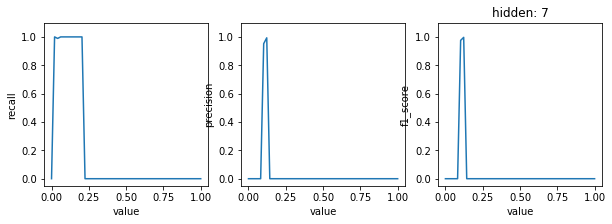

Averages precision: 0.13177124208672972, recall:0.6544914662469491, f1_score: 0.13254767872517095


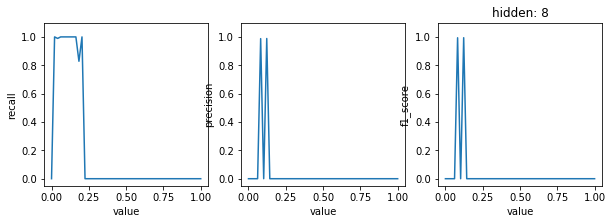

Averages precision: 0.22319076061752058, recall:0.6516442295091577, f1_score: 0.23545228874822835


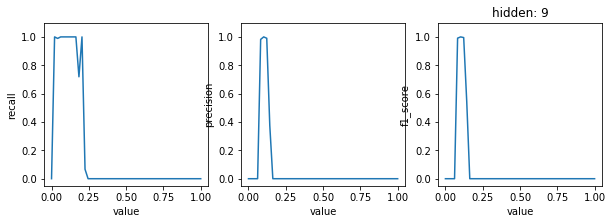

Averages precision: 0.1716062937096631, recall:0.6439011948145488, f1_score: 0.1824633392012863


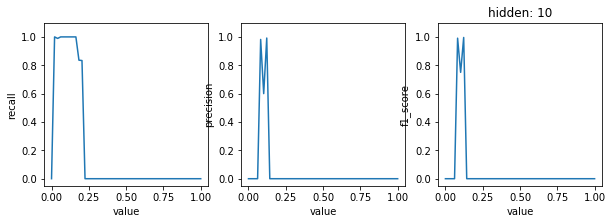

Averages precision: 0.5611344646161193, recall:0.7820086214076533, f1_score: 0.5564171134644661


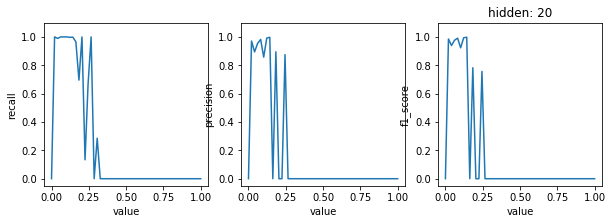

Averages precision: 0.6157988256973265, recall:0.7991018280342008, f1_score: 0.6162560792756546


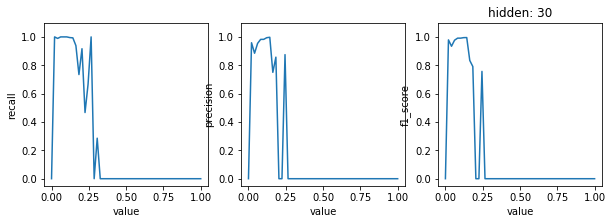

Averages precision: 0.6180855510329128, recall:0.8012913228312382, f1_score: 0.6186952745574025


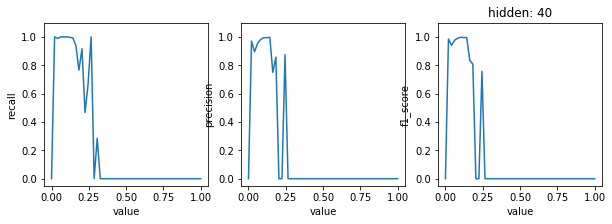

Averages precision: 0.5615384552969914, recall:0.8162429760708713, f1_score: 0.5604189058541512


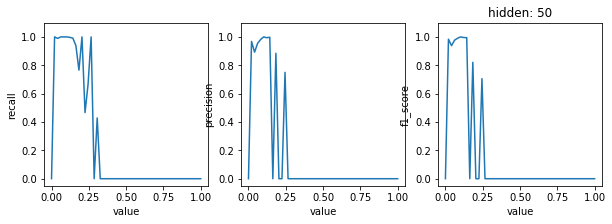

Averages precision: 0.5637209008373646, recall:0.8160040233845364, f1_score: 0.5612500532705337


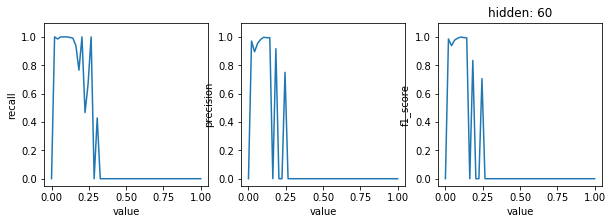

Averages precision: 0.6200957264592568, recall:0.8066079257004588, f1_score: 0.619479039136192


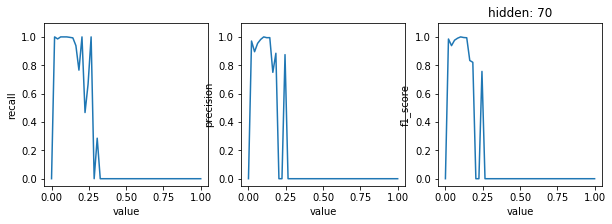

Averages precision: 0.5609954382775559, recall:0.8160040233845364, f1_score: 0.5600251518876047


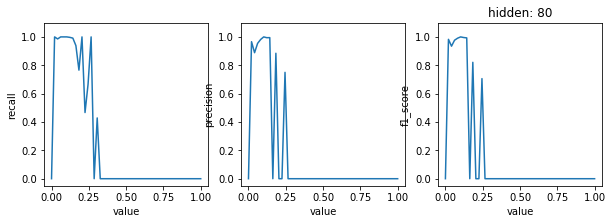

Averages precision: 0.6200957264592568, recall:0.8066079257004588, f1_score: 0.619479039136192


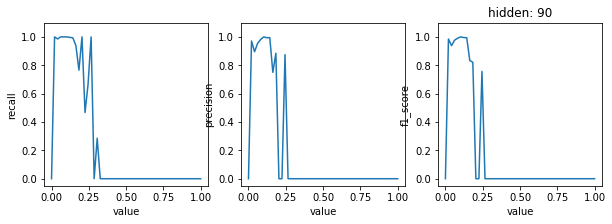

Averages precision: 0.561205114892917, recall:0.8160040233845364, f1_score: 0.5601313763246923


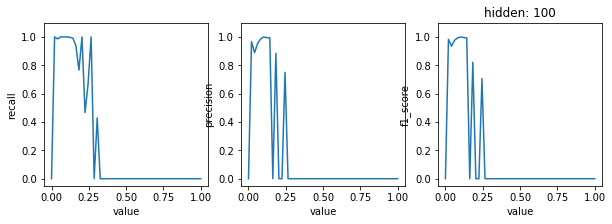

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


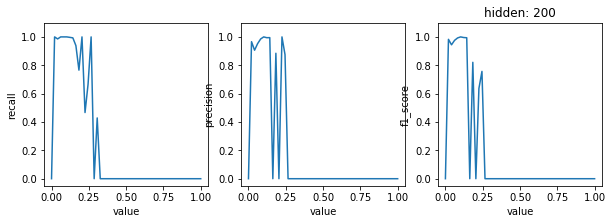

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


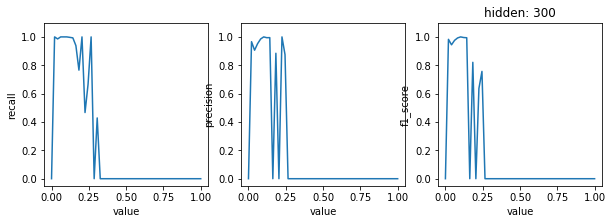

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


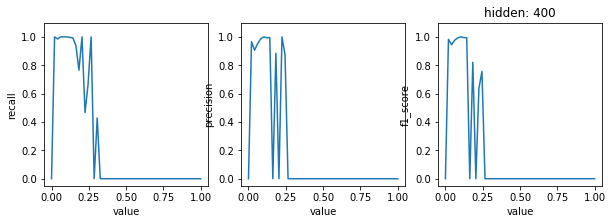

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


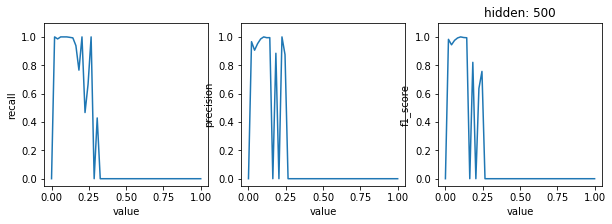

Averages precision: 0.636205114892917, recall:0.8161317352242683, f1_score: 0.606011256814197


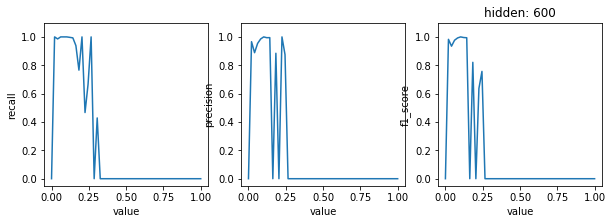

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


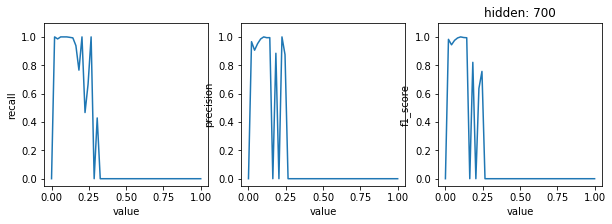

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


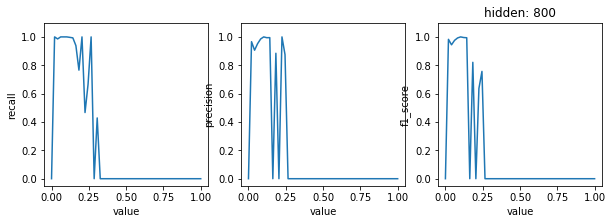

Averages precision: 0.6372626061508039, recall:0.8161317352242683, f1_score: 0.6065933921918183


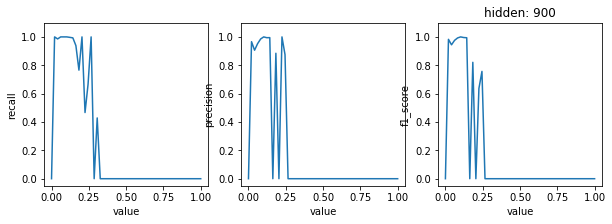

Averages precision: 0.636205114892917, recall:0.8161317352242683, f1_score: 0.606011256814197


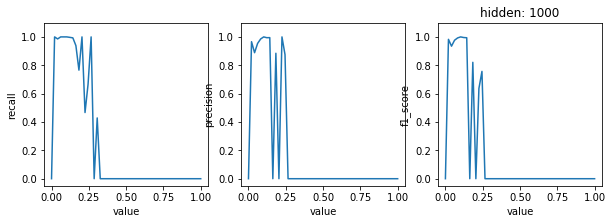

Averages precision: 0.636170045799346, recall:0.8130067343118611, f1_score: 0.6041450020749686


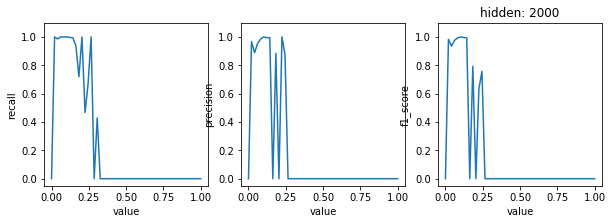

Averages precision: 0.6361700472022307, recall:0.8130067343118611, f1_score: 0.6041450028509374


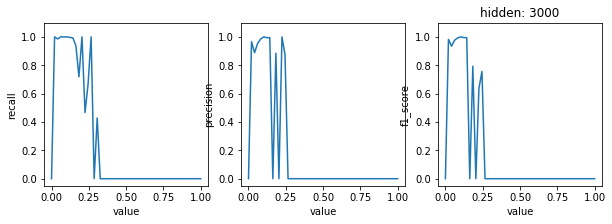

Averages precision: 0.6376585632195612, recall:0.8161317352242683, f1_score: 0.6066141835084834


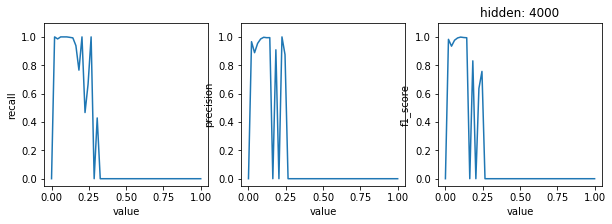

Averages precision: 0.6256812046421938, recall:0.7991318437956759, f1_score: 0.6181909927844115


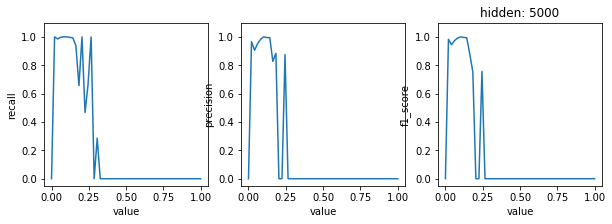

Averages precision: 0.686923525280091, recall:0.8042112088750409, f1_score: 0.6535802220186349


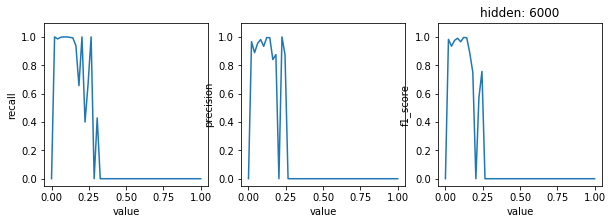

Averages precision: 0.6265084989218793, recall:0.8082565292966533, f1_score: 0.6239788646335391


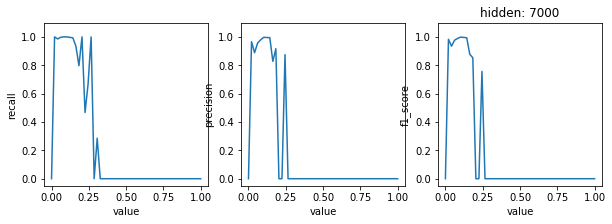

Averages precision: 0.6352662111454158, recall:0.8088400699676855, f1_score: 0.6011384866639119


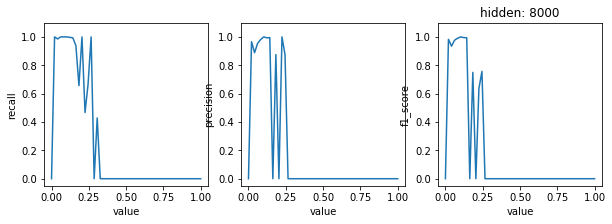

In [23]:
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []
relevance_threshold = relevance_function(1e-2)

max_val = np.max([ point[0] for point in data ])
max_val = max(max_val, np.max([ point[0] for point in data ]))

min_val = np.min([ point[0] for point in data ])
min_val = min(min_val, np.min([ point[0] for point in data ]))

print("max val in trace: {}".format(max_val))
print("min val in trace: {}".format(min_val))

for hidden_size in hidden_sizes:
    data = get_actual_predicted(trace_name, "jikes", hidden_size=hidden_size, history_size=40, 
                      model_type="lstm", output_file_location="/media/arjun/Shared/chaos/output_files/lstm")
    
    recall_vals = []
    precision_vals = []
    f1_vals = []
    vals = []
    
    for val in np.linspace(0, 1, 50):
        vals.append(val)
        
        recall_vals.append(recall(data, val, relevance_threshold=relevance_threshold))
        precision_vals.append(precision(data, val, relevance_threshold=relevance_threshold))
        f1_vals.append(f1_score(precision_vals[-1], recall_vals[-1]))
    
    recall_avg_list = []
    precision_avg_list = []
    f1_avg_list = []
    for idx, val in enumerate(np.linspace(0, 1, 50)):
        if existance_check(data, val, relevance_threshold=relevance_threshold):
            recall_avg_list.append(recall_vals[idx])
            precision_avg_list.append(precision_vals[idx])
            f1_avg_list.append(f1_vals[idx])
    
    avg_precision_list.append(np.average(precision_avg_list))
    avg_recall_list.append(np.average(recall_avg_list))
    avg_f1_list.append(np.average(f1_avg_list))
        
    print("Averages precision: {}, recall:{}, f1_score: {}".format(avg_precision_list[-1], 
                                                                   avg_recall_list[-1], 
                                                                   avg_f1_list[-1]))
    
    ax1=plt.subplot(1, 3, 1)
    ax2=plt.subplot(1, 3, 2)
    ax3=plt.subplot(1, 3, 3)
    
    ax1.figure.set_size_inches(10, 3)
    ax2.figure.set_size_inches(10, 3)

    ax1.plot(vals, recall_vals)
    ax1.set_ylim((-0.05, 1.1))
    ax1.set_xlabel("value")
    ax1.set_ylabel("recall")
    
    ax2.plot(vals, precision_vals)
    ax2.set_ylim((-0.05, 1.1))
    ax2.set_xlabel("value")
    ax2.set_ylabel("precision")
    
    ax3.plot(vals, f1_vals)
    ax3.set_ylim((-0.05, 1.1))
    ax3.set_xlabel("value")
    ax3.set_ylabel("f1_score")
    
    plt.title("hidden: {}".format(hidden_size))
    plt.show()

35
35


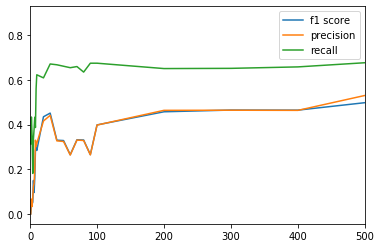

In [33]:
print(len(hidden_sizes))
print(len(avg_f1_list))

plt.plot(hidden_sizes, avg_f1_list, label="f1 score")
plt.plot(hidden_sizes, avg_precision_list, label="precision")
plt.plot(hidden_sizes, avg_recall_list, label="recall")
plt.xlim((0, 500))
plt.legend()
plt.show()

max val in trace: 0.3093642446824047
min val in trace: 0.022465752482887427
Averages precision: 0.0, recall:0.31330690572105296, f1_score: 0.0


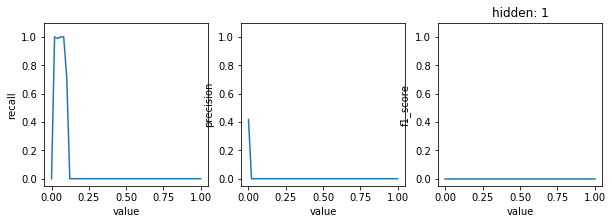

Averages precision: 0.06619357382219596, recall:0.4340892234662977, f1_score: 0.03382611410120925


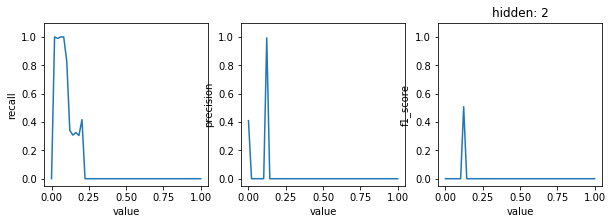

Averages precision: 0.03349662541734575, recall:0.35008650944983866, f1_score: 0.04458935633392228


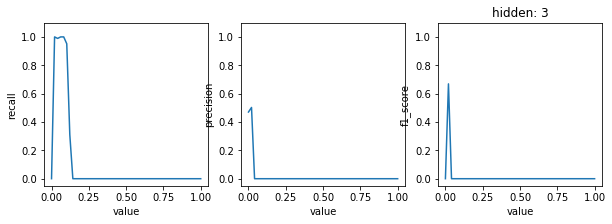

Averages precision: 0.07563271892764127, recall:0.1812124273373145, f1_score: 0.05278679025857483


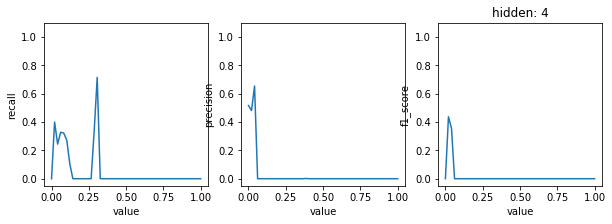

Averages precision: 0.12341754244093113, recall:0.33582262376279653, f1_score: 0.14996621838930171


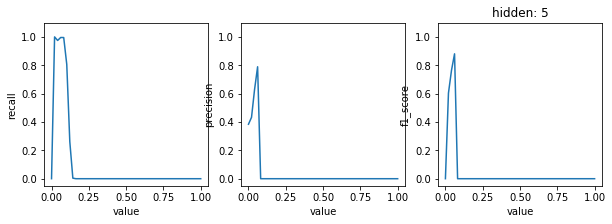

Averages precision: 0.1364204244006741, recall:0.3800118540831601, f1_score: 0.09580630960522463


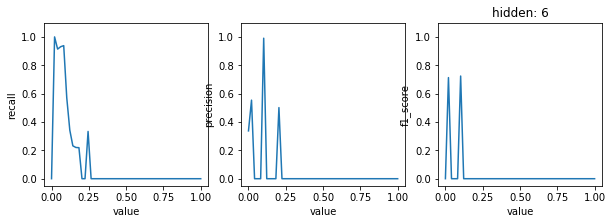

Averages precision: 0.20010440891445738, recall:0.4331193155685671, f1_score: 0.16066452771262899


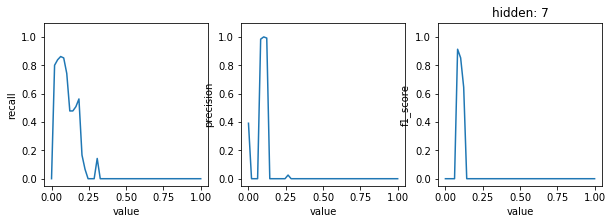

Averages precision: 0.33031236423373517, recall:0.3870613747357297, f1_score: 0.2843784015221709


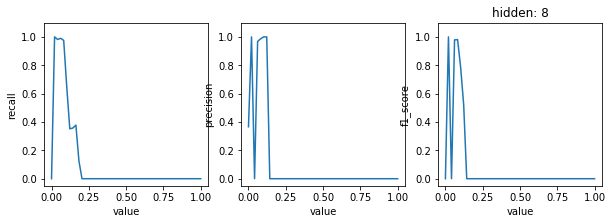

Averages precision: 0.30092408124650666, recall:0.5610067738064027, f1_score: 0.3029751436381774


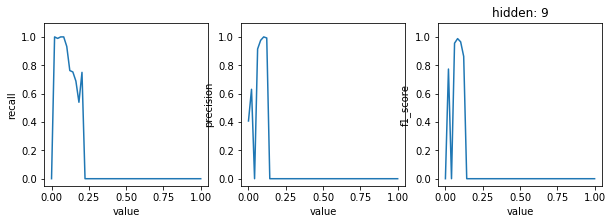

Averages precision: 0.31568938153511394, recall:0.6233136612572864, f1_score: 0.2841981460191111


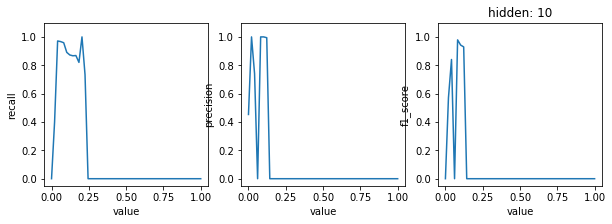

Averages precision: 0.4161933418531406, recall:0.6094277499162503, f1_score: 0.43517342349990723


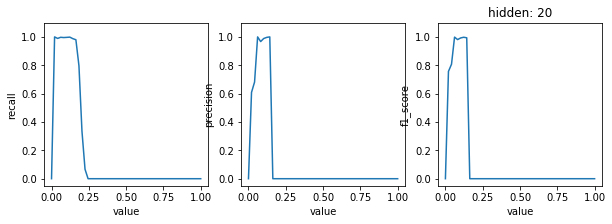

Averages precision: 0.4415096009183215, recall:0.6716498367434767, f1_score: 0.45158267568740434


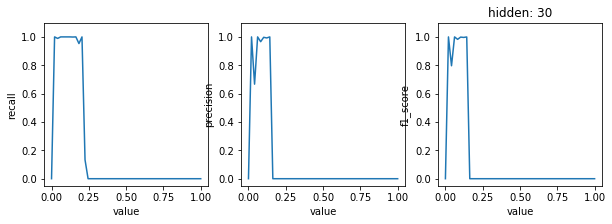

Averages precision: 0.3272336420294455, recall:0.6680719712326817, f1_score: 0.3302281631130589


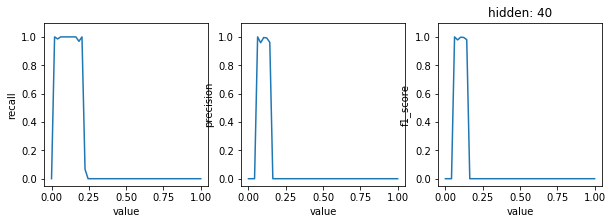

Averages precision: 0.3244248084209612, recall:0.6615441989270554, f1_score: 0.3286943959537666


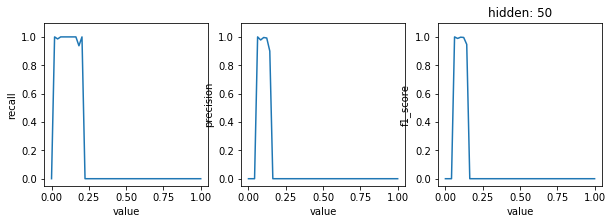

Averages precision: 0.2638706127899229, recall:0.6549775854038328, f1_score: 0.26525224726969665


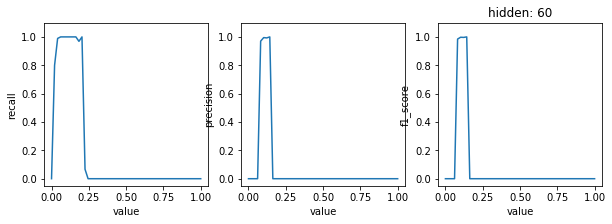

Averages precision: 0.33076422563009017, recall:0.6600817595771226, f1_score: 0.3320389515339803


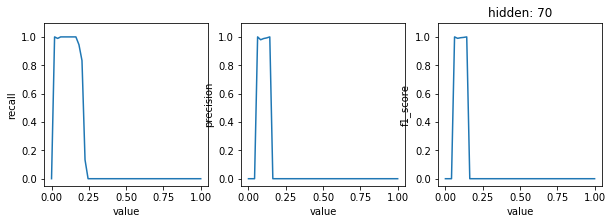

Averages precision: 0.3288879554151807, recall:0.6353289146402997, f1_score: 0.3310851255860977


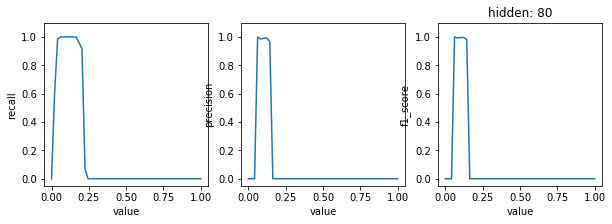

Averages precision: 0.2645730396485232, recall:0.6751164701454163, f1_score: 0.2656116751732971


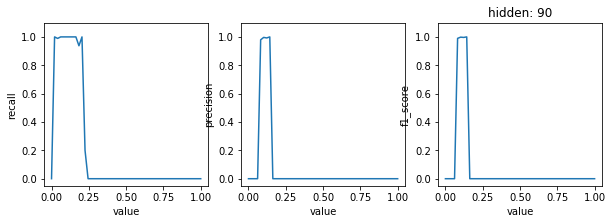

Averages precision: 0.3980666551283465, recall:0.6751164701454163, f1_score: 0.3986658186341411


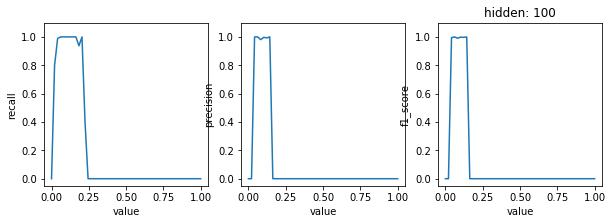

Averages precision: 0.46398922430403006, recall:0.651088679925722, f1_score: 0.45754912898729005


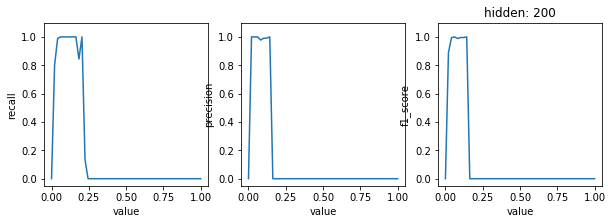

Averages precision: 0.4645374167446204, recall:0.6520609062952496, f1_score: 0.46523529644795797


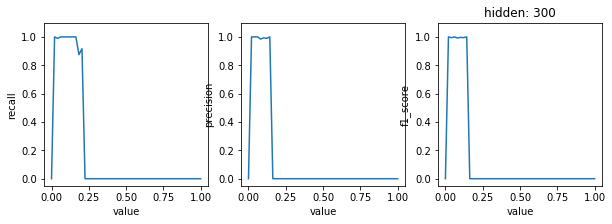

Averages precision: 0.4638500005528109, recall:0.6585746938935557, f1_score: 0.46488998110055124


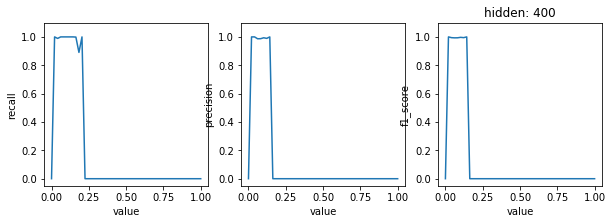

Averages precision: 0.5306163323021902, recall:0.6772097137454066, f1_score: 0.49827345380601645


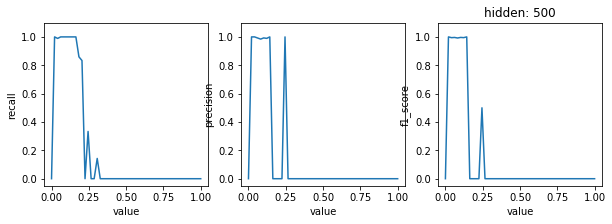

Averages precision: 0.5286893011352974, recall:0.6966087962024851, f1_score: 0.49695084564275277


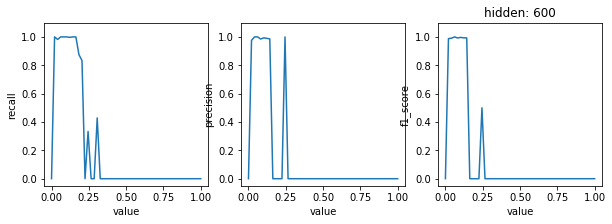

Averages precision: 0.5966895311914574, recall:0.6995539564893032, f1_score: 0.5589389043715015


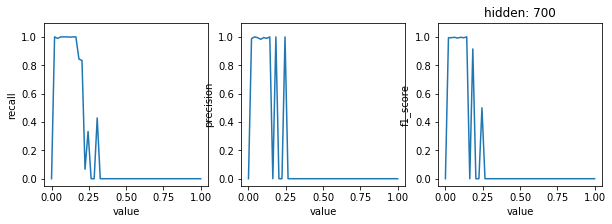

Averages precision: 0.5940580861208615, recall:0.7050457885200365, f1_score: 0.5711424034745212


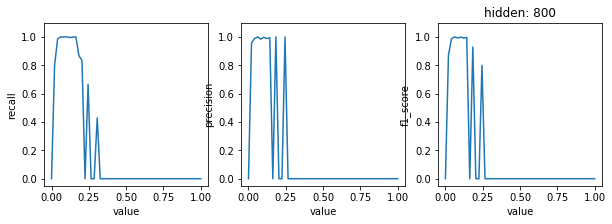

Averages precision: 0.6629182142876954, recall:0.7266353002097309, f1_score: 0.5946551408944437


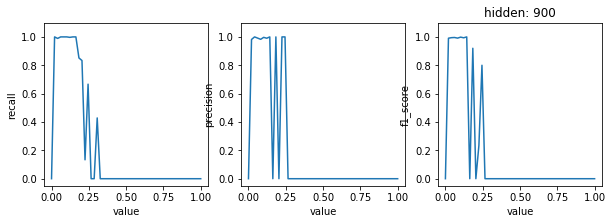

Averages precision: 0.7404754160623066, recall:0.7503225897557277, f1_score: 0.6839149995892729


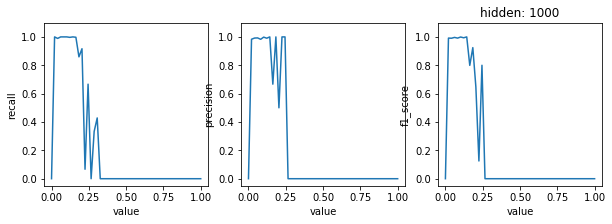

Averages precision: 0.7446587099040194, recall:0.7780096736298259, f1_score: 0.714745005537211


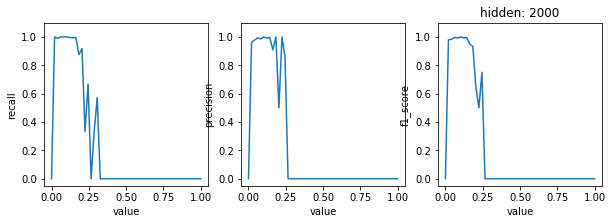

Averages precision: 0.7445461395051696, recall:0.863485298699566, f1_score: 0.7245107614132389


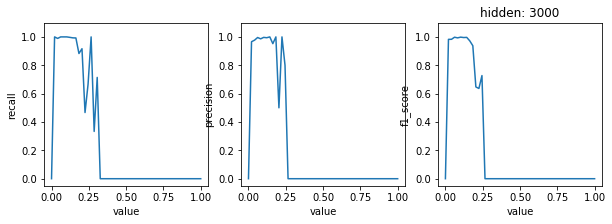

Averages precision: 0.7446227755044869, recall:0.8793841163989219, f1_score: 0.7342486971013982


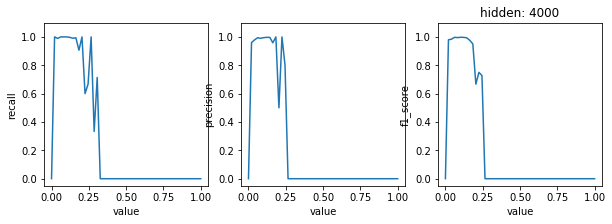

Averages precision: 0.7518608165737911, recall:0.8798159228582285, f1_score: 0.7399856465987092


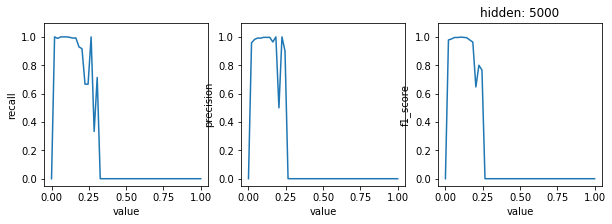

Averages precision: 0.7457296036428758, recall:0.8765161670105547, f1_score: 0.7349463796172208


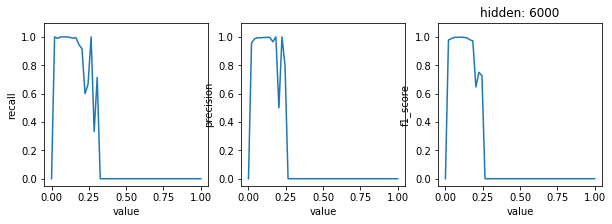

Averages precision: 0.7453280590526032, recall:0.8854744953428634, f1_score: 0.7388269146162982


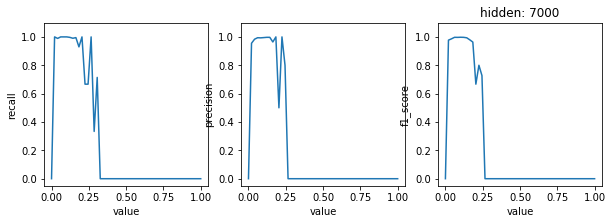

Averages precision: 0.7436529167315818, recall:0.8719632180469543, f1_score: 0.7350192588944469


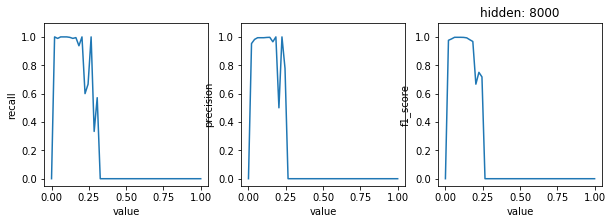

In [30]:
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []
relevance_threshold = relevance_function(1e-2)

max_val = np.max([ point[0] for point in data ])
max_val = max(max_val, np.max([ point[0] for point in data ]))

min_val = np.min([ point[0] for point in data ])
min_val = min(min_val, np.min([ point[0] for point in data ]))

print("max val in trace: {}".format(max_val))
print("min val in trace: {}".format(min_val))

for hidden_size in hidden_sizes:
    data = get_actual_predicted(trace_name, "jikes", hidden_size=hidden_size, history_size=40, 
                      model_type="lstm", output_file_location="/media/arjun/Shared/chaos/output_files")
    
    recall_vals = []
    precision_vals = []
    f1_vals = []
    vals = []
    
    for val in np.linspace(0, 1, 50):
        vals.append(val)
        
        recall_vals.append(recall(data, val, relevance_threshold=relevance_threshold))
        precision_vals.append(precision(data, val, relevance_threshold=relevance_threshold))
        f1_vals.append(f1_score(precision_vals[-1], recall_vals[-1]))
    
    recall_avg_list = []
    precision_avg_list = []
    f1_avg_list = []
    for idx, val in enumerate(np.linspace(0, 1, 50)):
        if existance_check(data, val, relevance_threshold=relevance_threshold):
            recall_avg_list.append(recall_vals[idx])
            precision_avg_list.append(precision_vals[idx])
            f1_avg_list.append(f1_vals[idx])
    
    avg_precision_list.append(np.average(precision_avg_list))
    avg_recall_list.append(np.average(recall_avg_list))
    avg_f1_list.append(np.average(f1_avg_list))
        
    print("Averages precision: {}, recall:{}, f1_score: {}".format(avg_precision_list[-1], 
                                                                   avg_recall_list[-1], 
                                                                   avg_f1_list[-1]))
    
    ax1=plt.subplot(1, 3, 1)
    ax2=plt.subplot(1, 3, 2)
    ax3=plt.subplot(1, 3, 3)
    
    ax1.figure.set_size_inches(10, 3)
    ax2.figure.set_size_inches(10, 3)

    ax1.plot(vals, recall_vals)
    ax1.set_ylim((-0.05, 1.1))
    ax1.set_xlabel("value")
    ax1.set_ylabel("recall")
    
    ax2.plot(vals, precision_vals)
    ax2.set_ylim((-0.05, 1.1))
    ax2.set_xlabel("value")
    ax2.set_ylabel("precision")
    
    ax3.plot(vals, f1_vals)
    ax3.set_ylim((-0.05, 1.1))
    ax3.set_xlabel("value")
    ax3.set_ylabel("f1_score")
    
    plt.title("hidden: {}".format(hidden_size))
    plt.show()

35
35


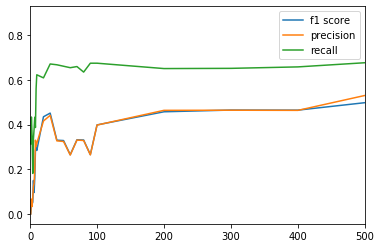

In [31]:
print(len(hidden_sizes))
print(len(avg_f1_list))

plt.plot(hidden_sizes, avg_f1_list, label="f1 score")
plt.plot(hidden_sizes, avg_precision_list, label="precision")
plt.plot(hidden_sizes, avg_recall_list, label="recall")
plt.xlim((0, 500))
plt.legend()
plt.show()

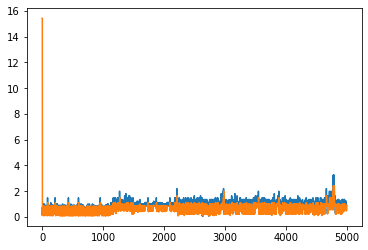

In [93]:

actual_list = [ data[i][0] for i in range(len(data)) ]
predicted_list = [ data[i][1] for i in range(len(data)) ]

plt.plot(range(len(data)), actual_list)
plt.plot(range(len(data)), predicted_list)
plt.show()

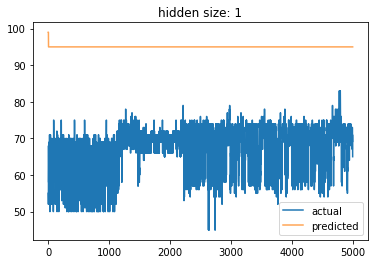

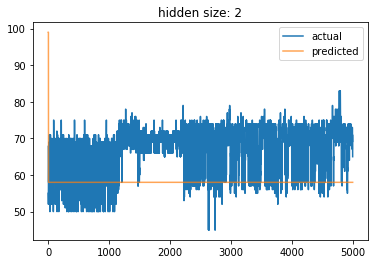

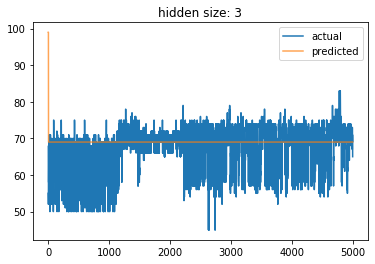

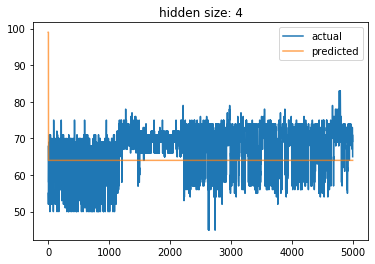

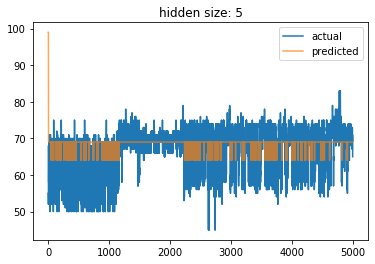

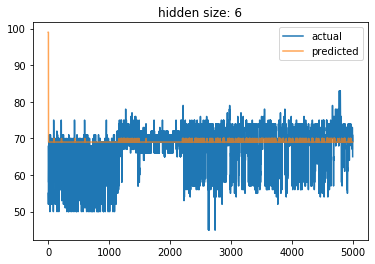

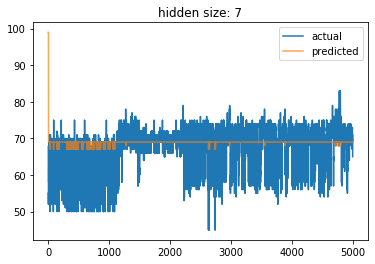

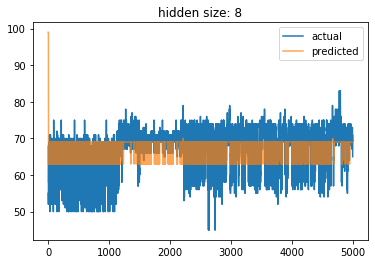

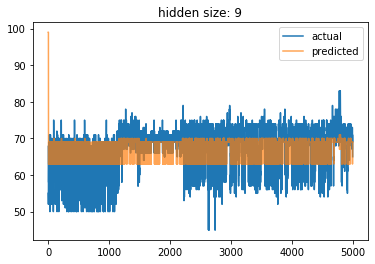

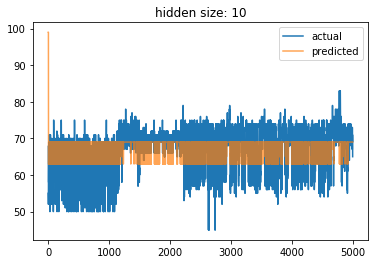

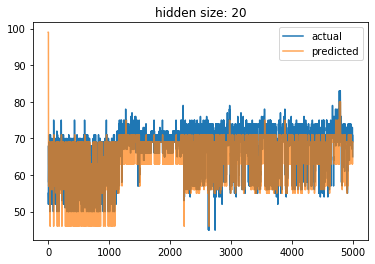

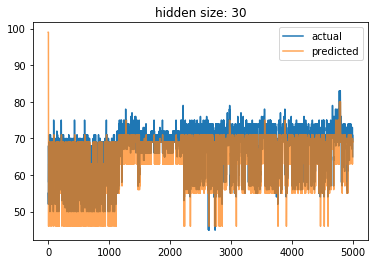

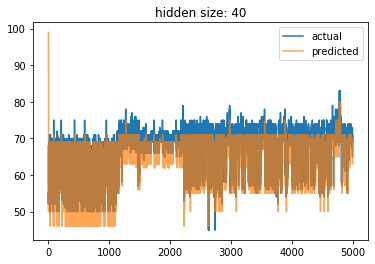

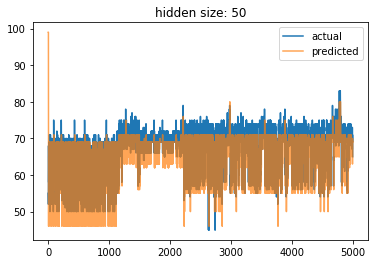

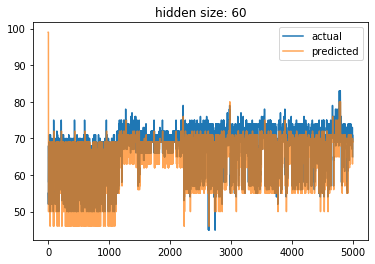

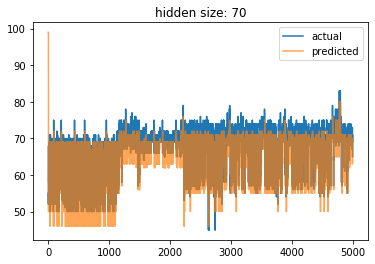

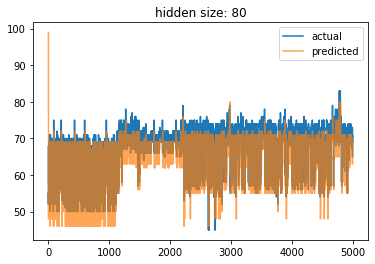

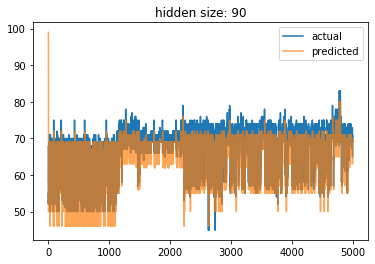

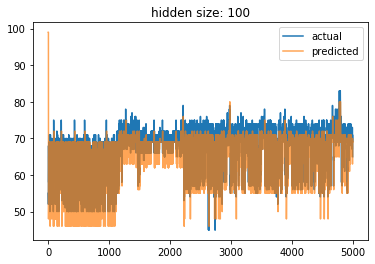

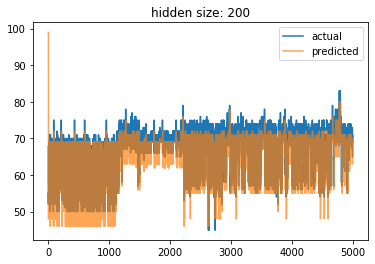

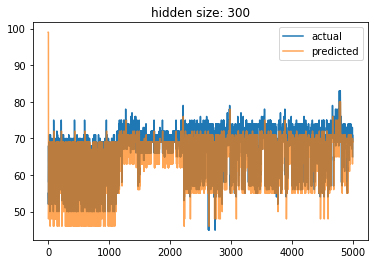

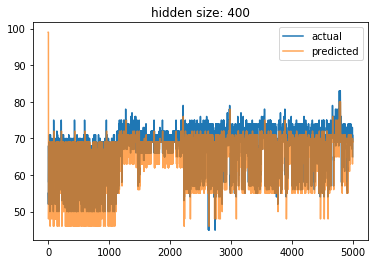

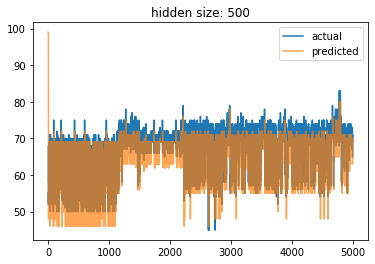

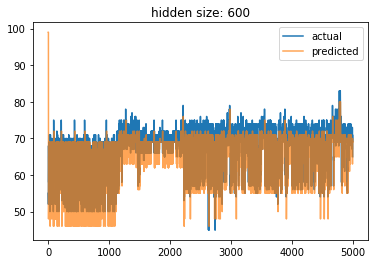

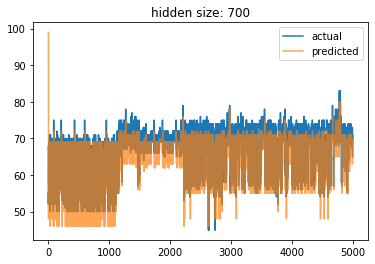

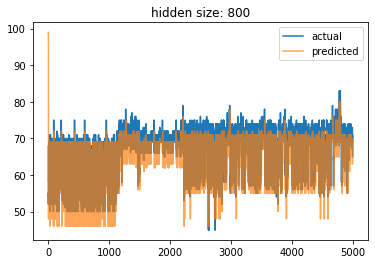

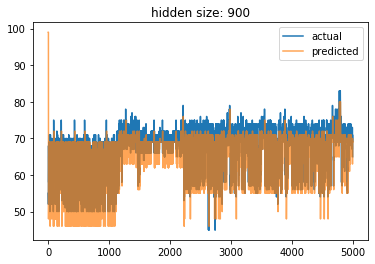

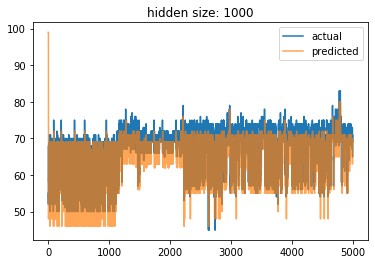

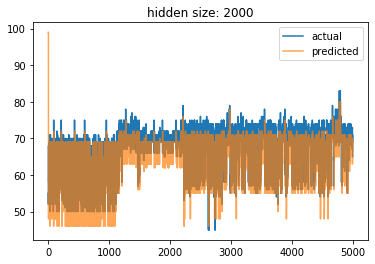

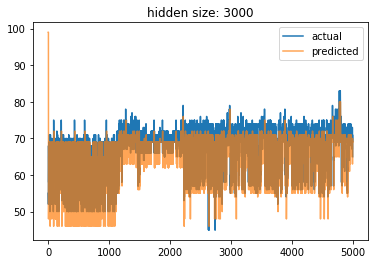

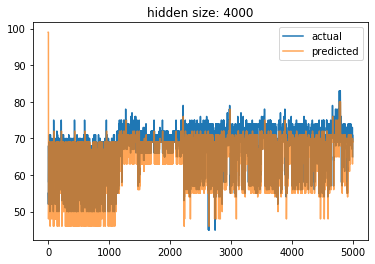

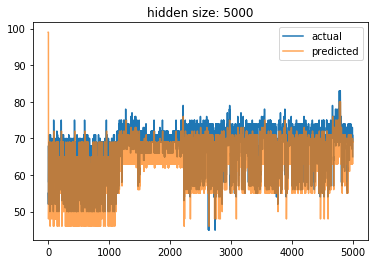

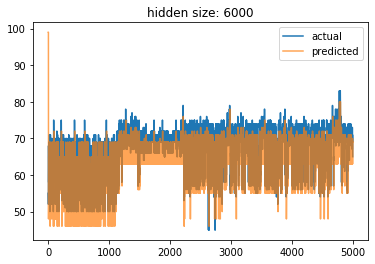

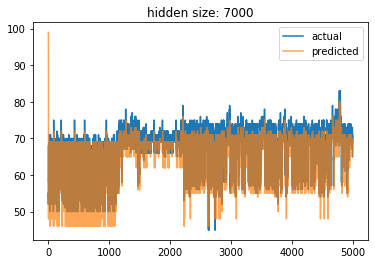

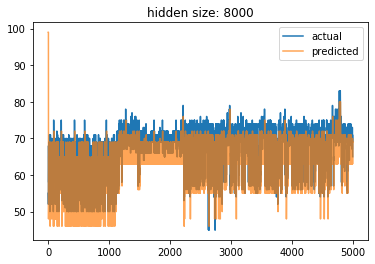

In [115]:
trace = plot_actual_predicted(trace_name, "jikes", history_size=40, 
                      model_type="lstm", output_file_location="/media/arjun/Shared/chaos/output_files/lstm")
# plot_actual_predicted("/media/arjun/Shared/chaos/output_files/lstm")

In [16]:
def exp_func(x, a, b, c):
    return a + b * np.exp(-c * x)


def poly1_func(x, a, b, c, d):
    return a + b * (1/(c*x + d))

def poly2_func(x, a, b, c, d, e):
    return a + b * (1/(c*np.power(x, 2) + d * x))

def poly3_func(x, a, b, c, d, e, f):
    return a + b * (1/(c*np.power(x, 3) + d * np.power(x, 2) + e * x + f))

func1 = exp_func
func2 = exp_func

rademacher1 = rademacher_list1[0]
rademacher2 = rademacher_list2[0]

popt1, pcov = curve_fit(func1, fcn_param_list[15:], rademacher1[15:])
popt2, pcov = curve_fit(func2, lstm_param_list[15:], rademacher2[15:])

[4.24261481e-04 1.00000000e+00 1.00000000e+00]
[6.83037593e-05 1.00000000e+00 1.00000000e+00]


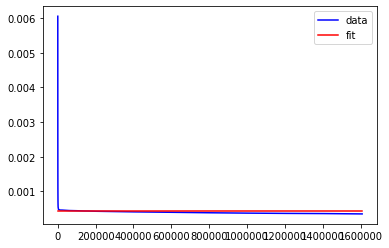

mse1: 1.1100504071776547e-06


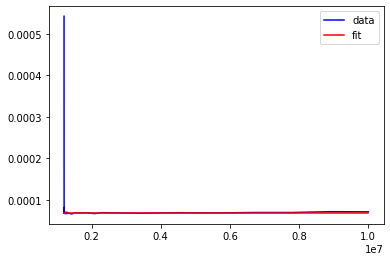

mse2: 6.821901338564427e-09


In [17]:
# print("a1: {}, a2: {}".format(popt1[0], popt2[0]))
print(popt1)
print(popt2)

f = [ func1(fcn_param, *popt1) for fcn_param in fcn_param_list ]
plt.plot(fcn_param_list, rademacher1, 'b-', label='data')
plt.plot(fcn_param_list, f, 'r-', label='fit')
plt.legend()
plt.show()

print("mse1: {}".format((1/len(f))*np.sum((np.array(f) - np.array(rademacher1))**2)))


f = [ func2(lstm_param, *popt2) for lstm_param in lstm_param_list ]
plt.plot(lstm_param_list, rademacher2, 'b-', label='data')
plt.plot(lstm_param_list, f, 'r-', label='fit')
plt.legend()
plt.show()

print("mse2: {}".format((1/len(f))*np.sum((np.array(f) - np.array(rademacher2))**2)))

In [ ]:
plot_actual_predicted(trace_name, "jikes", history_size=40, 
                      model_type="lstm", output_file_location="")

In [143]:
def root2(per, a, b, c, d):
    print(d)
    print(1/(per*a))
    print("2: ", np.exp(np.log(b) - np.log(per) - np.log(a)))
    print("2: ", d**2)
    print("3: ", 4 * c * ((b/(per*a))))
    print("4: ", d**2 - 4 * c * ((b/per*a)))
#     return (-d - np.sqrt(d**2 - 4 * c * (e - (b/per*a))))/(2*c)
    return (-d - np.sqrt(d**2 - 4 * c * (np.exp(np.log(b) - np.log(per) - np.log(a)))))/(2*c)

In [144]:
print(popt1)
print(root2(0.001, popt1[0], popt1[1], popt1[2], popt1[3]))

print(popt2)
print(root2(0.001, popt2[0], popt2[1], popt2[2], popt2[3]))

[ 3.95847214e-04  1.81867677e+00 -6.34970181e-06  1.47838264e+00
  1.00000000e+00]
1.4783826370617148
2526227.2016360406
2:  4594390.732336748
2:  2.1856152215655498
3:  -116.69204462131445
4:  2.185633506627457
974965.9295525678
[6.88173783e-05 1.07086577e+00 9.94337563e+00 1.00000000e+00
 1.00000000e+00]
1.0
14531213.269181844
2:  15560978.861760998
2:  1.0
3:  618914631.9340383
4:  -1.9310754403134882
nan


/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [ ]:
for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list1[idx]
    plt.plot(hidden_sizes, rademacher_history, label="model: {}, jvm: {}".format("fcn", jvm))

for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list2[idx]
    plt.plot(hidden_sizes, rademacher_history, label="model: {}, jvm: {}".format("lstm", jvm))
    
plt.legend()
plt.ylabel("Empirical Rademacher Complexity")
plt.xlabel("Hidden Layer Size")
plt.ylim((0.0003, 0.0004))
plt.tight_layout()
plt.show()

In [ ]:
for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list1[idx]
    plt.plot(hidden_sizes, rademacher_history, label="model: {}, jvm: {}".format("fcn", jvm))

for idx, jvm in enumerate(jvm_list):
    rademacher_history = rademacher_list2[idx]
    plt.plot(hidden_sizes, rademacher_history, label="model: {}, jvm: {}".format("lstm", jvm))
    
plt.legend()
plt.ylabel("Empirical Rademacher Complexity")
plt.xlabel("Hidden Layer Size")
plt.ylim((0, 0.0001))
plt.tight_layout()
plt.show()

In [ ]:
trace = plot_actual_predicted(trace_name, "jikes", history_size=40, model_type="lstm")